In [75]:
from prophet import Prophet
import pandas as pd
from datetime import datetime, timedelta
import altair as alt
from collections import deque
import numpy as np
import math
import time

fit_predict_model is a function which will take in a dataframe, fit the Prophet model to it and then give the forecasted results back for the next N minutes

In [281]:
def fit_predict_model(dataframe,periods=15,changepoint_prior_scale=0.10,daily_seasonality=False, weekly_seasonality=False, yearly_seasonality=False):
    prophet_model = Prophet(growth="logistic",changepoint_prior_scale=changepoint_prior_scale,daily_seasonality=daily_seasonality, weekly_seasonality=weekly_seasonality, yearly_seasonality=yearly_seasonality)
    prophet_model.fit(dataframe)
    future = prophet_model.make_future_dataframe(periods=periods,freq="1MIN",include_history=False,)
    future["cap"] = 1.0
    future_forecast = prophet_model.predict(future)
    future_forecast["timestamp"] = future_forecast["ds"]
    future_forecast = future_forecast.set_index("timestamp")
    return future_forecast

detect_anomalies determines if each of the actual values is within the lower and upper bound.

In [19]:
def detect_anomalies(forecast):
    forecasted = forecast[['ds','trend', 'yhat', 'yhat_lower', 'yhat_upper', 'fact', 'upper_std', 'lower_std']].copy()
    #forecast['fact'] = df['y']
    forecasted.loc[forecasted['fact'] > forecasted['upper_std'], 'anomaly'] = 1
    forecasted.loc[forecasted['fact'] < forecasted['lower_std'], 'anomaly'] = 1

    #anomaly importances
    forecasted['importance'] = 0
    forecasted.loc[forecasted['anomaly'] ==1, 'importance'] = \
        (forecasted['fact'] - forecasted['yhat_upper'])/forecast['fact']
    forecasted.loc[forecasted['anomaly'] ==-1, 'importance'] = \
        (forecasted['yhat_lower'] - forecasted['fact'])/forecast['fact']
    
    return forecasted

plot_anomalies is a function that will plot the lower and upper bounds for each data point in addition to the actual value. Anomalies are marked by red meaning the data point is outside of the lower and upper bound range.

In [317]:
def plot_anomalies(forecasted):
    interval = alt.Chart(forecasted).mark_area(interpolate="basis", color = '#7FC97F').encode(
    x=alt.X('ds:T', axis=alt.Axis(format='%H:%M'), title ='date'),
    y='upper_std',
    y2='lower_std',
    tooltip=['ds', 'fact', 'lower_std', 'upper_std']
    ).interactive().properties(
        title='Anomaly Detection'
    )

    fact = alt.Chart(forecasted[forecasted.anomaly==0]).mark_circle(size=15, opacity=0.7, color = 'Black').encode(
        x='ds:T',
        y=alt.Y('fact', title='CPU Utilization Percentage'),    
        tooltip=['ds', 'fact', 'lower_std', 'upper_std']
    ).interactive()

    anomalies = alt.Chart(forecasted[forecasted.anomaly!=0]).mark_circle(size=30, color = 'Red').encode(
        x='ds:T',
        y=alt.Y('fact', title='CPU Utilization Percentage'),    
        tooltip=['ds', 'fact', 'lower_std', 'upper_std']
    ).interactive()

    return alt.layer(interval, fact, anomalies)\
              .properties(width=870, height=450)\
              .configure_title(fontSize=20)

In [339]:
dataset_values = []
date_time_vals = []
with open('clusterwide_cpu_usage_percentage.txt','r') as cmd:
    for line in cmd:
        line = line.rstrip().split(",")
        date_time = datetime.fromtimestamp(float(line[0]))
        date_time_vals.append(float(line[0]))
        metric_dict = {"ds": date_time.strftime("%Y-%m-%d %H:%M:%S"), "y": float(line[1]) / 100.0}
        dataset_values.append(metric_dict)

Inject outlier data into dataset to see if Prophet is able to adjust its forecasts over time.

In [340]:
last_one = date_time_vals[-1] + 60
icr = 0.70
for i in range(500):
    if i % 50 == 0:
        icr += 0.01
    new_dict = {"ds": (datetime.fromtimestamp(last_one)).strftime("%Y-%m-%d %H:%M:%S"), "y": icr}
    last_one += 60
    dataset_values.append(new_dict)
    

Code to read in the values from CSV file

Define data_range to determine how much of the dataset you would want to work with

In [341]:
data_range = 1200

Define time_interval for how often FB Prophet model will be retrained.

In [342]:
time_interval = 10

Define the maximum amount of training data which the FB prophet model will be trained on

In [343]:
training_metric_limit = 1440

Define the changepoint_range for the Prophet model

In [344]:
changepoint_prior_scale = 0.05

Retrieve the first data_range values of the dataset

In [345]:
data_values = dataset_values[:data_range]

For the initial training of the FB Prophet model, retrieve the first time_interval data points from the dataset

In [346]:
training_dataset = data_values[:time_interval]

Turn the training_dataset list into a Pandas dataframe so it can be taken as input into Prophet model

In [347]:
training_dataset_df = pd.DataFrame(training_dataset)

Create the first Prophet model which will be trained on the initial time_interval data points

In [348]:
training_dataset_df['cap'] = 1.0
future_forecast = fit_predict_model(training_dataset_df,periods=time_interval,changepoint_prior_scale=changepoint_prior_scale)

INFO:prophet:n_changepoints greater than number of observations. Using 7.


In [349]:
%%time
counter = 0
num_anomalies = 0
prediction_results = []
interval_metrics = []
column_names =  ['trend', 'yhat', 'yhat_lower', 'yhat_upper']
anomaly_count = []
metric_values = []
for i in range(time_interval,len(data_values)):
    interval_metrics.append(data_values[i])
    current_metric_datetime = data_values[i]["ds"]
    current_metric_value = data_values[i]["y"]
    nearest_index = future_forecast.index.get_loc(current_metric_datetime, method="nearest")
    nearest_index_value = future_forecast.iloc[[nearest_index]]
    metric_data_obtained = {"fact": current_metric_value, "ds": current_metric_datetime}
    for c in column_names:
        metric_data_obtained[c] = nearest_index_value[c].values[0]
    yhat_lower = nearest_index_value['yhat_lower'].values[0]
    yhat_upper = nearest_index_value['yhat_upper'].values[0]
    yhat_value = nearest_index_value['yhat'].values[0]
    yhat_lower = max(0, yhat_lower)
    upper_std = abs(yhat_upper - yhat_value)
    lower_std = abs(yhat_value - yhat_lower)
    metric_data_obtained['lower_std'] = max(0, yhat_lower - 2 * lower_std)
    metric_data_obtained['upper_std'] = min(1.0,yhat_upper + (2 * upper_std))
    metric_data_obtained['yhat_lower'] = yhat_lower
    metric_data_obtained['yhat_upper'] = yhat_upper
    metric_data_obtained['anomaly'] = 0
    interval_metrics.append(data_values[i])
    if (current_metric_value < yhat_lower - (2 * lower_std)) or (current_metric_value > yhat_upper + (2 * upper_std)):
        metric_data_obtained['anomaly'] = 1
        num_anomalies += 1
    prediction_results.append(metric_data_obtained)
    counter += 1
    if counter == time_interval:
        counter = 0
        if len(training_dataset) + len(interval_metrics) > training_metric_limit:
            training_dataset = training_dataset[time_interval:]
        training_dataset += interval_metrics
        anomaly_count.append(num_anomalies)
        num_anomalies = 0
        training_dataset_df = pd.DataFrame(training_dataset)
        training_dataset_df['cap'] = 1.0
        future_forecast = fit_predict_model(training_dataset_df,periods=time_interval,changepoint_prior_scale=changepoint_prior_scale)
        interval_metrics = []

INFO:prophet:n_changepoints greater than number of observations. Using 23.


CPU times: user 3min 27s, sys: 698 ms, total: 3min 27s
Wall time: 3min 28s


In [350]:
pred_result_df = pd.DataFrame(prediction_results)

,fact,ds,trend,yhat,yhat_lower,yhat_upper,lower_std,upper_std,anomaly
1040,0.8,2021-07-17 08:47:40,0.792826,0.792826,0.712788,0.873607,0.552711,1.0,0
1041,0.8,2021-07-17 08:48:40,0.792979,0.792979,0.706889,0.877944,0.534710,1.0,0
1042,0.8,2021-07-17 08:49:40,0.793132,0.793132,0.712426,0.880093,0.551014,1.0,0
1043,0.8,2021-07-17 08:50:40,0.793284,0.793284,0.712742,0.872668,0.551659,1.0,0
1044,0.8,2021-07-17 08:51:40,0.793436,0.793436,0.709129,0.872379,0.540515,1.0,0
1045,0.8,2021-07-17 08:52:40,0.793589,0.793589,0.707841,0.869231,0.536346,1.0,0
1046,0.8,2021-07-17 08:53:40,0.793741,0.793741,0.707493,0.872567,0.534996,1.0,0
1047,0.8,2021-07-17 08:54:40,0.793893,0.793893,0.708424,0.873569,0.537487,1.0,0
1048,0.8,2021-07-17 08:55:40,0.794045,0.794045,0.714864,0.873807,0.556501,1.0,0
1049,0.8,2021-07-17 08:56:40,0.794197,0.794197,0.715169,0.871933,0.557114,1.0,0


See the number of anomalies predicted for each time_interval. A cold start is expected initially.

In [352]:
print(anomaly_count)

[2, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [353]:
plot_anomalies(pred_result_df)

alt.LayerChart(...)

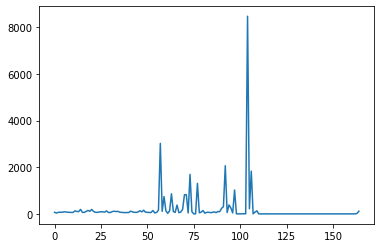

In [118]:
import matplotlib.pyplot as plt
plotting_values = []
for d in data_values:
    plotting_values.append(d['y'])
plt.plot(range(len(plotting_values)), plotting_values)